# DL - HM02.1.1

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Defines

In [2]:
MELBOURNE_DATASET = "D:/M.A/T2/Deep Learning/Assignments/HM2 - Es.Kiani - 40311614/RBF/daily-minimum-temperatures-in-melbourne.csv"
Parkinsons_DATASET = "D:/M.A/T2/Deep Learning/Assignments/HM2 - Es.Kiani - 40311614/RBF/Parkinsons.csv"

# Activation functions

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

def softmax_derivative(x):
    s = softmax(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def rbf(x, center, sigma=1.0):
    return np.exp(-np.sum((x - center) ** 2) / (2 * sigma ** 2))
    
def rbf_derivative(x, center, sigma=1.0):
    rbf_val = rbf(x, center, sigma)
    return -rbf_val * (x - center) / (sigma ** 2)

def leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.1):
    return np.where(x > 0, 1, alpha)

In [4]:
def choose_function(x, name, center=None, sigma=1.0):
    if name == "sigmoid":
        return sigmoid(x)
        
    elif name == "softmax":
        return softmax(x)
        
    elif name == "relu":
        return relu(x)
    
    elif name == "rbf":
        return rbf(x, center, sigma)
        
    elif name == "leaky_relu":
        return leaky_relu(x)
        
    return x

In [5]:
def choose_derivative(x, name, center=None, sigma=1.0):
    if name == "sigmoid":
        return sigmoid_derivative(x)
        
    elif name == "softmax":
        return softmax_derivative(x)
        
    elif name == "relu":
        return relu_derivative(x)
        
    elif name == "rbf":
        return rbf_derivative(x, center, sigma)
        
    elif name == "leaky_relu":
        return leaky_relu_derivative(x)
    
    return np.ones_like(x)

# Time series preparation

In [6]:
def create_time_series(data, num_inputs, steps_ahead=3):
    X = np.zeros((data.shape[0] - num_inputs - steps_ahead + 1, num_inputs))
    Y = np.zeros((data.shape[0] - num_inputs - steps_ahead + 1))
    for i in range(X.shape[0]):
        X[i] = data[i:i + num_inputs]
        Y[i] = data[i + num_inputs + steps_ahead - 1]
    return X, Y

# Load & Normalization

In [7]:
def load_and_normalize_data(file_path):
    data = pd.read_csv(file_path)
    temperatures = data['Daily minimum temperatures in Melbourne, Australia, 1981-1990'].to_numpy()
    min_val, max_val = np.min(temperatures), np.max(temperatures)
    normalized_data = (temperatures - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val

# Train/Test

In [8]:
def split_data(X, Y, train_ratio=0.7, val_ratio=0.1):
    num_data = X.shape[0]
    num_train = int(num_data * train_ratio)
    num_val = int(num_data * val_ratio)
    num_test = num_data - num_train - num_val
    
    indices = np.random.permutation(num_data)
    X, Y = X[indices], Y[indices]
    
    X_train, Y_train = X[:num_train], Y[:num_train]
    X_val, Y_val = X[num_train:num_train + num_val], Y[num_train:num_train + num_val]
    X_test, Y_test = X[num_train + num_val:], Y[num_train + num_val:]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# Hyperparameters

In [9]:
num_inputs = 30
n1_rbf = 20
n2 = 15
n3 = 10
n1_perceptron = 5
n2_perceptron = 1
eta_rbf = 0.25
eta_auto = 0.25
eta_perceptron = 0.25
epochs_auto = 50
epochs_perceptron = 50
sigma_rbf = 0.75

# Data loading

In [10]:
data, min_val, max_val = load_and_normalize_data(MELBOURNE_DATASET)
X, Y = create_time_series(data, num_inputs, steps_ahead=3)
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X, Y)

# Initialization

In [11]:
centers_enc = X_train[np.random.choice(X_train.shape[0], n1_rbf, replace=False)]
centers_dec = np.random.uniform(-1, 1, (n1_rbf, n1_rbf))
w2_e = np.random.uniform(-1, 1, (n2, n1_rbf))
w3_e = np.random.uniform(-1, 1, (n3, n2))
w3_d = np.random.uniform(-1, 1, (n2, n3))
w2_d = np.random.uniform(-1, 1, (n1_rbf, n2))
w1_d = np.random.uniform(-1, 1, (num_inputs, n1_rbf))
w1_p = np.random.uniform(-1, 1, (n1_perceptron, n3))
w2_p = np.random.uniform(-1, 1, (n2_perceptron, n1_perceptron))

# Training

In [13]:
for t in range(epochs_auto):
    for i in range(X_train.shape[0]):
        X = X_train[i] 
        
        # Feedforward Autoencoder - Encoder
        o1_e = np.array([rbf(X, c, sigma_rbf) for c in centers_enc])
        net2_e = w2_e.dot(o1_e)  
        o2_e = leaky_relu(net2_e)  
        net3_e = w3_e.dot(o2_e)  
        o3_e = leaky_relu(net3_e)  
        
        # Decoder
        net3_d = w3_d.dot(o3_e)  
        o3_d = leaky_relu(net3_d)  
        net2_d = w2_d.dot(o3_d)  
        o2_d = np.array([rbf(net2_d, c, sigma_rbf) for c in centers_dec])  
        net1_d = w1_d.dot(o2_d) 
        o1_d = sigmoid(net1_d)  
        
        # Backpropagation
        error = X - o1_d  
        delta1_d = error * sigmoid_derivative(net1_d) 
        
        delta2_d = np.zeros(n1_rbf) 
        for j in range(n1_rbf):
            grad_rbf = rbf_derivative(net2_d, centers_dec[j], sigma_rbf)  
            delta2_d[j] = np.sum(w1_d[:, j] * delta1_d) * grad_rbf[j] 
        
        delta3_d = w2_d.T.dot(delta2_d) * leaky_relu_derivative(net3_d)  
        delta3_e = w3_d.T.dot(delta3_d) * leaky_relu_derivative(net3_e) 
        delta2_e = w3_e.T.dot(delta3_e) * leaky_relu_derivative(net2_e)  
        
        # Update weights
        w1_d += eta_auto * np.outer(delta1_d, o2_d) 
        w2_d += eta_auto * np.outer(delta2_d, o3_d) 
        w3_d += eta_auto * np.outer(delta3_d, o3_e) 
        w3_e += eta_auto * np.outer(delta3_e, o2_e) 
        w2_e += eta_auto * np.outer(delta2_e, o1_e) 
        
        # Update centers
        for j in range(n1_rbf):
            grad_center_enc = rbf_derivative(X, centers_enc[j], sigma_rbf)  
            centers_enc[j] += eta_rbf * grad_center_enc * np.sum(delta2_e * w2_e[:, j])  
            grad_center_dec = rbf_derivative(net2_d, centers_dec[j], sigma_rbf)  
            centers_dec[j] += eta_rbf * grad_center_dec * np.sum(delta3_d * w2_d[j, :])  
    
    if t % 10 == 0:
        print(f"Epoch {t}")

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40


In [14]:
mse_train = np.zeros(epochs_perceptron)
mse_test = np.zeros(epochs_perceptron)

In [15]:
def compute_encoder_output(X, w2_e, w3_e, centers_enc, sigma=1.0):
    rbf_layer = np.array([choose_function(X, "rbf", center=c, sigma=sigma) for c in centers_enc])
    net2_e = w2_e.dot(rbf_layer)
    o2_e = choose_function(net2_e, "leaky_relu")
    net3_e = w3_e.dot(o2_e)
    o3_e = choose_function(net3_e, "leaky_relu")
    return o3_e

In [16]:
def compute_perceptron_output(autoencoder_output, w1_p, w2_p):
    net1_p = w1_p.dot(autoencoder_output)
    o1_p = choose_function(net1_p, "sigmoid")
    net2_p = w2_p.dot(o1_p)
    o2_p = choose_function(net2_p, "sigmoid")
    return o2_p

In [17]:
def get_predictions(X_data, w2_e, w3_e, w1_p, w2_p, centers_enc, sigma=1.0):
    predictions = []
    for X in X_data:
        autoencoder_out = compute_encoder_output(X, w2_e, w3_e, centers_enc, sigma)
        pred = compute_perceptron_output(autoencoder_out, w1_p, w2_p)
        predictions.append(pred)
    return np.array(predictions)

In [18]:
for t in range(epochs_perceptron):
    for i in range(X_train.shape[0]):
        autoencoder_out = compute_encoder_output(X_train[i], w2_e, w3_e, centers_enc, sigma_rbf) 
        
        # Forward pass through Perceptron
        net1_p = w1_p.dot(autoencoder_out)
        o1_p = sigmoid(net1_p)  
        net2_p = w2_p.dot(o1_p) 
        o2_p = sigmoid(net2_p)  
        
        # Backpropagation
        error = Y_train[i] - o2_p  
        delta2_p = error * sigmoid_derivative(net2_p)  
        delta1_p = w2_p.T.dot(delta2_p) * sigmoid_derivative(net1_p)  
        
        w2_p += eta_perceptron * np.outer(delta2_p, o1_p) 
        w1_p += eta_perceptron * np.outer(delta1_p, autoencoder_out)  
    
    predictions_train = get_predictions(X_train, w2_e, w3_e, w1_p, w2_p, centers_enc, sigma_rbf)
    predictions_test = get_predictions(X_test, w2_e, w3_e, w1_p, w2_p, centers_enc, sigma_rbf)
    
    mse_train[t] = np.mean((Y_train - predictions_train) ** 2)
    mse_test[t] = np.mean((Y_test - predictions_test) ** 2)
    
    if t % 10 == 0:
        print(f"Epoch {t}")

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40


In [19]:
predictions_train_denorm = predictions_train * (max_val - min_val) + min_val
predictions_test_denorm = predictions_test * (max_val - min_val) + min_val
Y_train_denorm = Y_train * (max_val - min_val) + min_val
Y_test_denorm = Y_test * (max_val - min_val) + min_val

# Result

MSE Train: 0.03550956928954799
MSE Test: 0.03674066325356826


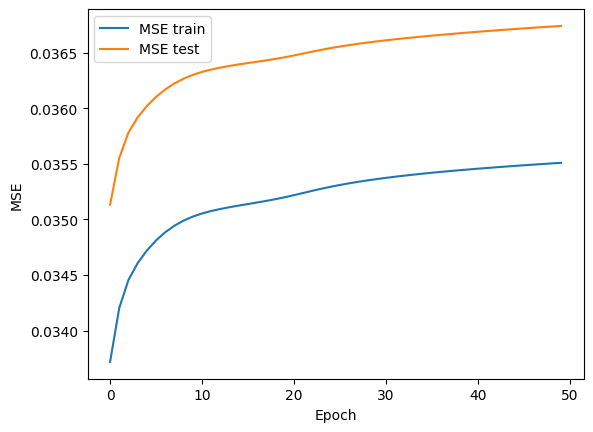

In [20]:
print("MSE Train:", mse_train[-1])
print("MSE Test:", mse_test[-1])
plt.plot(mse_train, label="MSE train")
plt.plot(mse_test, label="MSE test")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [21]:
def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

In [22]:
Y_train_denorm = denormalize(Y_train, min_val, max_val).flatten()
Y_test_denorm = denormalize(Y_test, min_val, max_val).flatten()
predictions_train_denorm = denormalize(predictions_train, min_val, max_val).flatten()
predictions_test_denorm = denormalize(predictions_test, min_val, max_val).flatten()

In [23]:
# Y_train_denorm = Y_train_denorm.flatten()
# predictions_train_denorm = predictions_train_denorm.flatten()
# Y_test_denorm = Y_test_denorm.flatten()
# predictions_test_denorm = predictions_test_denorm.flatten()

# print("Shape of Y_train_denorm after flattening:", Y_train_denorm.shape)
# print("Shape of predictions_train_denorm after flattening:", predictions_train_denorm.shape)

In [24]:
print("Sample Actual vs Predicted (Train Data, Denormalized):")
for i in range(5):
    print(f"Sample {i+1}: Actual = {Y_train_denorm[i]:.2f}, Predicted = {predictions_train_denorm[i]:.2f}")

print("\nSample Actual vs Predicted (Test Data, Denormalized):")
for i in range(5):
    print(f"Sample {i+1}: Actual = {Y_test_denorm[i]:.2f}, Predicted = {predictions_test_denorm[i]:.2f}")

Sample Actual vs Predicted (Train Data, Denormalized):
Sample 1: Actual = 18.00, Predicted = 13.27
Sample 2: Actual = 9.90, Predicted = 12.78
Sample 3: Actual = 13.30, Predicted = 13.84
Sample 4: Actual = 15.00, Predicted = 15.39
Sample 5: Actual = 9.70, Predicted = 14.17

Sample Actual vs Predicted (Test Data, Denormalized):
Sample 1: Actual = 14.50, Predicted = 14.76
Sample 2: Actual = 12.00, Predicted = 9.73
Sample 3: Actual = 7.60, Predicted = 7.34
Sample 4: Actual = 19.50, Predicted = 15.39
Sample 5: Actual = 13.40, Predicted = 11.00


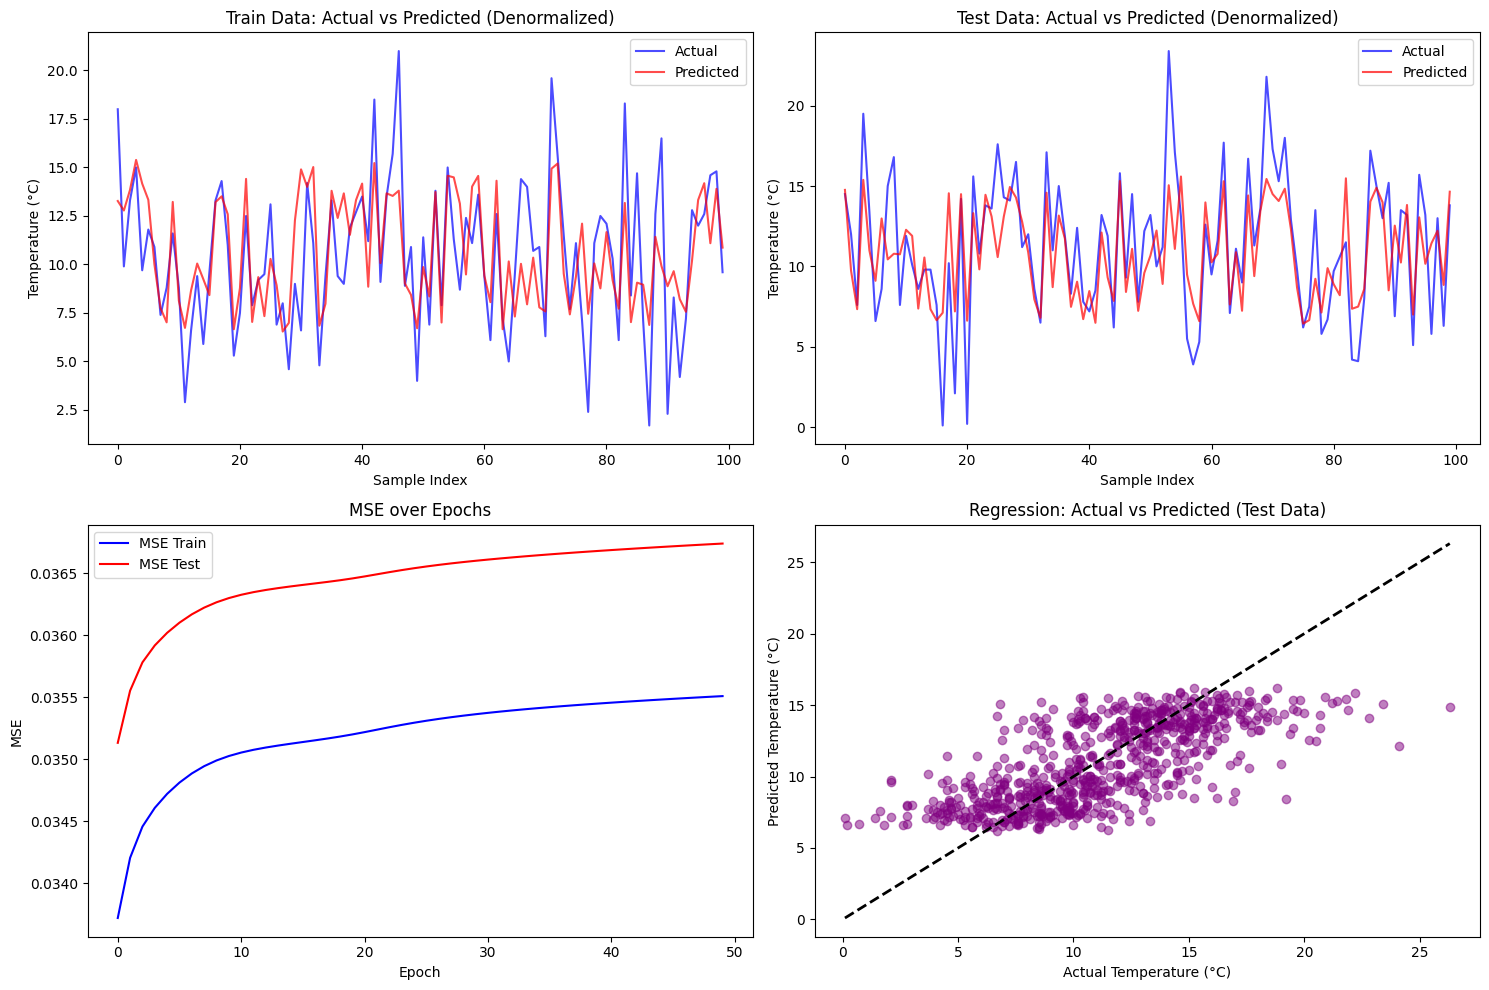

In [25]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(Y_train_denorm[:100], label="Actual", color="blue", alpha=0.7)
plt.plot(predictions_train_denorm[:100], label="Predicted", color="red", alpha=0.7)
plt.title("Train Data: Actual vs Predicted (Denormalized)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(Y_test_denorm[:100], label="Actual", color="blue", alpha=0.7)
plt.plot(predictions_test_denorm[:100], label="Predicted", color="red", alpha=0.7)
plt.title("Test Data: Actual vs Predicted (Denormalized)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(mse_train, label="MSE Train", color="blue")
plt.plot(mse_test, label="MSE Test", color="red")
plt.title("MSE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

plt.subplot(2, 2, 4)
plt.scatter(Y_test_denorm, predictions_test_denorm, color="purple", alpha=0.5)
plt.plot([Y_test_denorm.min(), Y_test_denorm.max()], [Y_test_denorm.min(), Y_test_denorm.max()], 'k--', lw=2)
plt.title("Regression: Actual vs Predicted (Test Data)")
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")

plt.tight_layout()
plt.show()

In [26]:
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

In [27]:
mae_train = calculate_mae(Y_train, predictions_train)
mae_test = calculate_mae(Y_test, predictions_test)
mae_train_denorm = calculate_mae(Y_train_denorm, predictions_train_denorm)
mae_test_denorm = calculate_mae(Y_test_denorm, predictions_test_denorm)

print("Performance Metrics (Normalized):")
print(f"Train MSE: {mse_train[-1]:.6f}")
print(f"Test MSE: {mse_test[-1]:.6f}")
print(f"Train MAE: {mae_train:.6f}")
print(f"Test MAE: {mae_test:.6f}")

print("\nPerformance Metrics (Denormalized):")
print(f"Train MSE (Denorm): {(mse_train[-1] * (max_val - min_val)**2):.6f}")
print(f"Test MSE (Denorm): {(mse_test[-1] * (max_val - min_val)**2):.6f}")
print(f"Train MAE (Denorm): {mae_train_denorm:.6f}")
print(f"Test MAE (Denorm): {mae_test_denorm:.6f}")


Performance Metrics (Normalized):
Train MSE: 0.035510
Test MSE: 0.036741
Train MAE: 0.151807
Test MAE: 0.154140

Performance Metrics (Denormalized):
Train MSE (Denorm): 24.561614
Test MSE (Denorm): 25.413149
Train MAE (Denorm): 2.255952
Test MAE (Denorm): 2.322914


In [28]:
performance_data = {
    "Metric": ["MSE (Normalized)", "MAE (Normalized)", "MSE (Denormalized)", "MAE (Denormalized)"],
    "Train": [mse_train[-1], mae_train, mse_train[-1] * (max_val - min_val)**2, mae_train_denorm],
    "Test": [mse_test[-1], mae_test, mse_test[-1] * (max_val - min_val)**2, mae_test_denorm]
}

performance_df = pd.DataFrame(performance_data)
print("\nSummary of Performance Metrics:")
print(performance_df.to_string(index=False))


Summary of Performance Metrics:
            Metric     Train      Test
  MSE (Normalized)  0.035510  0.036741
  MAE (Normalized)  0.151807  0.154140
MSE (Denormalized) 24.561614 25.413149
MAE (Denormalized)  2.255952  2.322914


# Visualize

In [ ]:
# from graphviz import Digraph

# dot = Digraph(comment='Network Architecture')

# # لایه‌ها
# dot.node('I', 'Input\n(30)', shape='box')
# dot.node('E1', 'RBF\n(20)', shape='box')
# dot.node('E2', 'Leaky ReLU\n(15)', shape='box')
# dot.node('E3', 'Leaky ReLU\n(10)', shape='box')
# dot.node('D1', 'Leaky ReLU\n(15)', shape='box')
# dot.node('D2', 'RBF\n(20)', shape='box')
# dot.node('D3', 'Sigmoid\n(30)', shape='box')
# dot.node('P1', 'Sigmoid\n(5)', shape='box')
# dot.node('P2', 'Sigmoid\n(1)', shape='box')

# # اتصالات
# dot.edge('I', 'E1', label='Encoder')
# dot.edge('E1', 'E2')
# dot.edge('E2', 'E3')
# dot.edge('E3', 'D1', label='Decoder')
# dot.edge('D1', 'D2')
# dot.edge('D2', 'D3')
# dot.edge('E3', 'P1', label='Perceptron')
# dot.edge('P1', 'P2')

# # ذخیره و نمایش
# dot.render('network_architecture', format='png', view=True)